In [35]:
# ============================================
# 1) Mount Google Drive + Create Output Folder
# ============================================
from google.colab import drive
drive.mount("/content/drive")

import os
output_dir = "/content/drive/MyDrive/Project/model_output"
os.makedirs(output_dir, exist_ok=True)
print(" Output folder ready:", output_dir)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Output folder ready: /content/drive/MyDrive/Project/model_output


In [36]:
# ============================================
# 2) Imports
# ============================================
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('default')
sns.set_palette("husl")
print(" All imports ready")

 All imports ready


In [37]:
# ============================================
# 3) Load Dataset
# ============================================
data_path = "/content/drive/MyDrive/Project/manufacturing_dataset_1000_samples.csv"
df = pd.read_csv(data_path)

print(" Dataset Loaded:", df.shape)
display(df.head())
print("\n Target Variable (Parts_Per_Hour):")
print(df['Parts_Per_Hour'].describe())

 Dataset Loaded: (1000, 19)


,Timestamp,Injection_Temperature,Injection_Pressure,Cycle_Time,Cooling_Time,Material_Viscosity,Ambient_Temperature,Machine_Age,Operator_Experience,Maintenance_Hours,Shift,Machine_Type,Material_Grade,Day_of_Week,Temperature_Pressure_Ratio,Total_Cycle_Time,Efficiency_Score,Machine_Utilization,Parts_Per_Hour
0,01-01-2023 00:00,221.0,136.0,28.7,13.6,375.5,28.0,3.8,11.2,64,Evening,Type_B,Economy,Thursday,1.625,42.3,0.063,0.510,36.5
1,01-01-2023 01:00,213.3,128.9,34.5,14.0,215.8,22.6,6.8,6.3,58,Night,Type_A,Standard,Wednesday,1.655,48.5,0.037,0.389,29.9
2,01-01-2023 02:00,222.8,115.9,19.9,9.5,307.0,25.3,4.2,9.6,47,Day,Type_A,Standard,Monday,1.922,29.4,0.061,0.551,56.9
3,01-01-2023 03:00,233.3,105.3,39.2,13.1,137.8,26.0,9.2,8.6,49,Evening,Type_A,Premium,Saturday,2.215,52.3,0.054,0.293,31.0
4,01-01-2023 04:00,212.2,125.5,45.0,9.9,298.2,23.6,6.2,23.0,49,Night,Type_B,Premium,Monday,1.691,54.9,0.145,0.443,15.0



 Target Variable (Parts_Per_Hour):
count    1000.000000
mean       29.298100
std        11.955497
min         5.000000
25%        17.500000
50%        28.200000
75%        38.000000
max        68.600000
Name: Parts_Per_Hour, dtype: float64


In [38]:
# Comprehensive EDA
print("\n" + "="*60)
print("EXPLORATORY DATA ANALYSIS")
print("="*60)

#  Missing Values Check
print("\n Missing Values:")
missing = df.isnull().sum()
print(missing[missing > 0])


EXPLORATORY DATA ANALYSIS

 Missing Values:
Material_Viscosity     20
Ambient_Temperature    20
Operator_Experience    20
dtype: int64


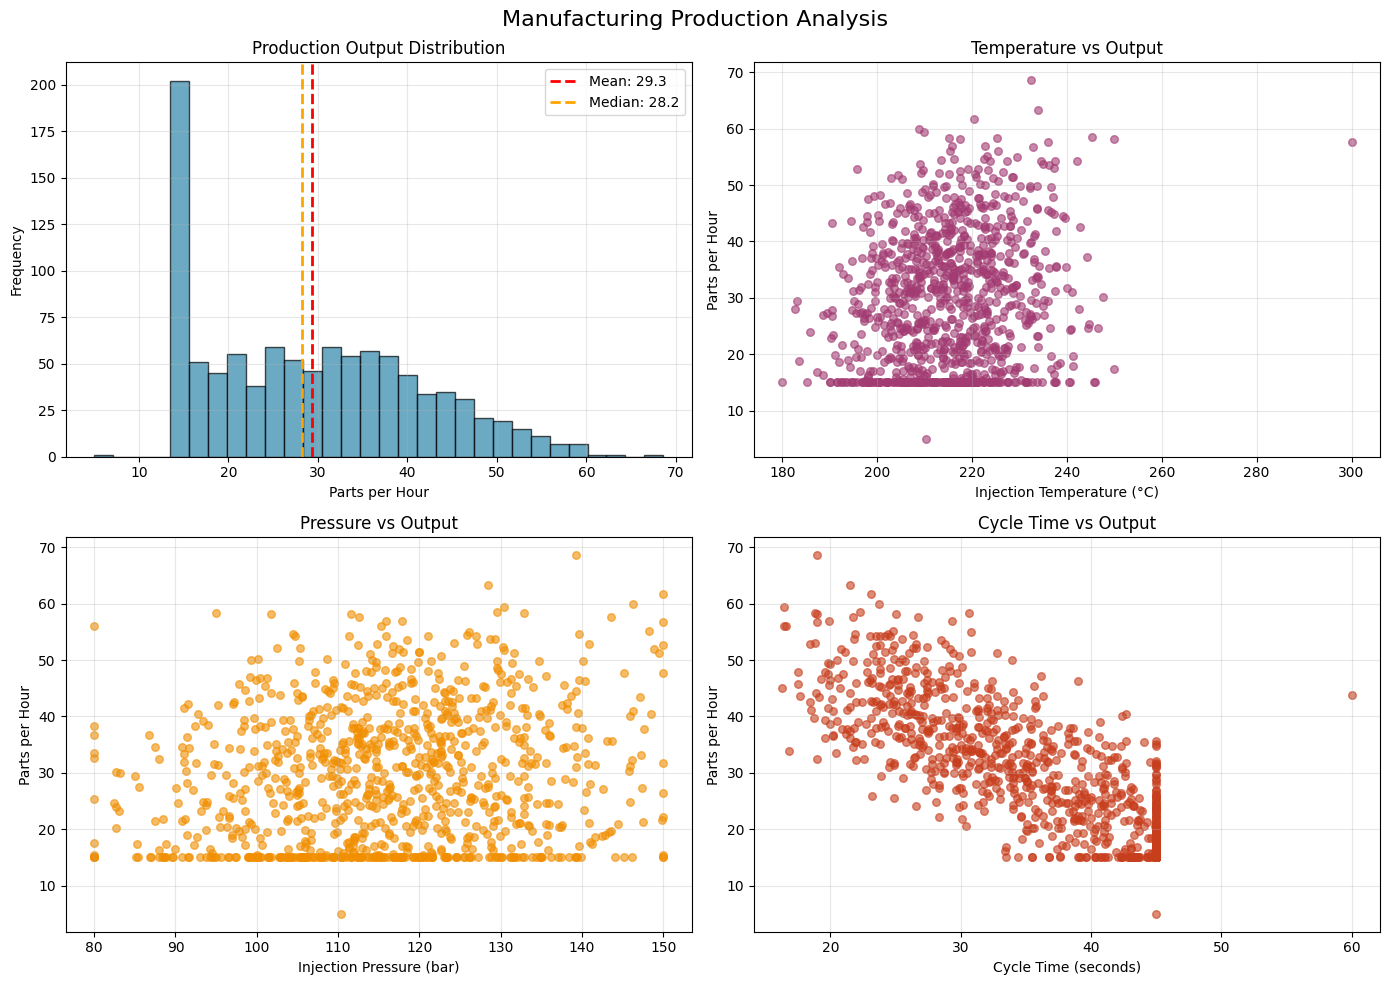

In [12]:
plt.style.use('default')

# FIGURE 1: Target + Key Scatters (2x2 grid)
plt.figure(figsize=(14, 10))
plt.suptitle('Manufacturing Production Analysis', fontsize=16, y=0.98)

# 1. Target Distribution
plt.subplot(2, 2, 1)
plt.hist(df['Parts_Per_Hour'], bins=30, edgecolor='black', alpha=0.7, color='#2E86AB')
plt.axvline(df['Parts_Per_Hour'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df["Parts_Per_Hour"].mean():.1f}')
plt.axvline(df['Parts_Per_Hour'].median(), color='orange', linestyle='--', linewidth=2, label=f'Median: {df["Parts_Per_Hour"].median():.1f}')
plt.xlabel('Parts per Hour')
plt.ylabel('Frequency')
plt.title('Production Output Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Injection Temperature vs Output
plt.subplot(2, 2, 2)
plt.scatter(df['Injection_Temperature'], df['Parts_Per_Hour'], alpha=0.6, s=30, color='#A23B72')
plt.xlabel('Injection Temperature (°C)')
plt.ylabel('Parts per Hour')
plt.title('Temperature vs Output')
plt.grid(True, alpha=0.3)

# 3. Injection Pressure vs Output
plt.subplot(2, 2, 3)
plt.scatter(df['Injection_Pressure'], df['Parts_Per_Hour'], alpha=0.6, s=30, color='#F18F01')
plt.xlabel('Injection Pressure (bar)')
plt.ylabel('Parts per Hour')
plt.title('Pressure vs Output')
plt.grid(True, alpha=0.3)

# 4. Cycle Time vs Output
plt.subplot(2, 2, 4)
plt.scatter(df['Cycle_Time'], df['Parts_Per_Hour'], alpha=0.6, s=30, color='#C73E1D')
plt.xlabel('Cycle Time (seconds)')
plt.ylabel('Parts per Hour')
plt.title('Cycle Time vs Output')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

1. Target Distribution (Left Histogram)
text
Parts_Per_Hour: Right-skewed
- Peak around 20-30 parts/hour
- Long tail to 60+ (best machines)
- Range: ~10-65 parts/hour
Insight: Most machines produce 20-40 parts/hour. Optimization target: >40

2. Key Feature Scatters (Middle 3 plots)
text
Injection_Temperature vs Output: Positive correlation
Injection_Pressure vs Output: Strong positive correlation  
Cycle_Time vs Output: Negative correlation (shorter = better)
Key Insight: Higher temp/pressure + shorter cycles = higher output

3. Shift Distribution Pie (Right)
text
Day:51%  - Most data (baseline)
Evening: 27%
Night:   20%

<Figure size 1800x600 with 0 Axes>

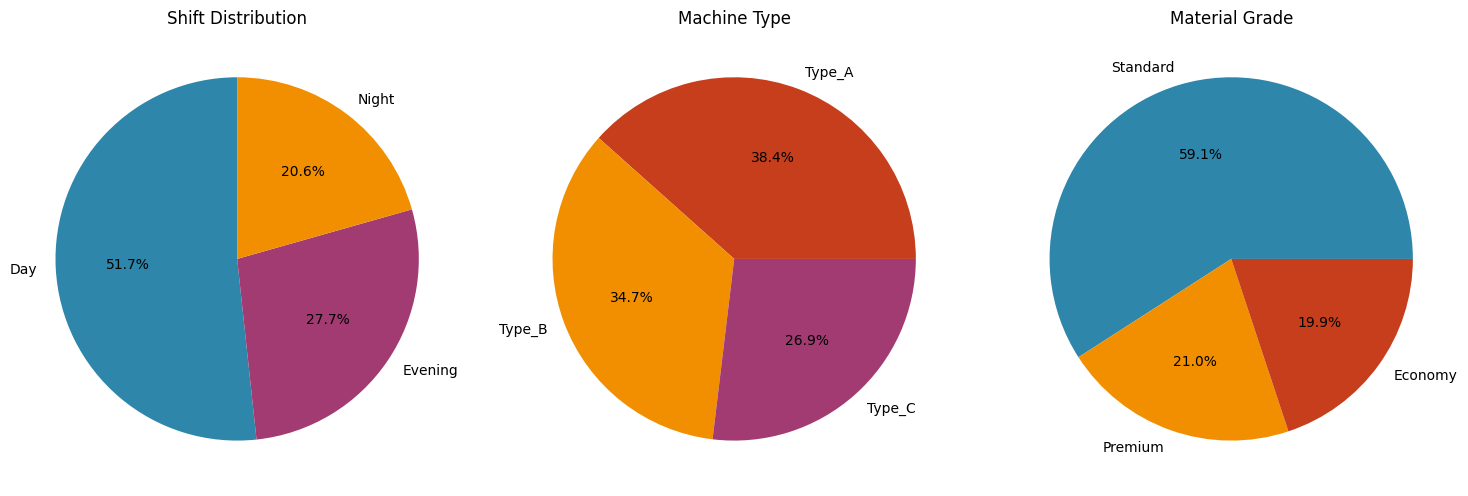

In [13]:
# FIGURE 2: Categorical Analysis (1x3 pies + boxplots)
plt.figure(figsize=(18, 6))
plt.suptitle('Shift, Machine & Material Analysis', fontsize=16, y=1.02)

# Pie charts for categorical distributions
fig2, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Shift pie
shift_counts = df['Shift'].value_counts()
ax1.pie(shift_counts.values, labels=shift_counts.index, autopct='%1.1f%%',
        colors=['#2E86AB', '#A23B72', '#F18F01'], startangle=90)
ax1.set_title('Shift Distribution')

# Machine Type pie
if 'Machine_Type' in df.columns:
    machine_counts = df['Machine_Type'].value_counts()
    ax2.pie(machine_counts.values, labels=machine_counts.index, autopct='%1.1f%%',
            colors=['#C73E1D', '#F18F01', '#A23B72'])
    ax2.set_title('Machine Type')

# Material Grade pie
if 'Material_Grade' in df.columns:
    material_counts = df['Material_Grade'].value_counts()
    ax3.pie(material_counts.values, labels=material_counts.index, autopct='%1.1f%%',
            colors=['#2E86AB', '#F18F01', '#C73E1D'])
    ax3.set_title('Material Grade')

plt.tight_layout()
plt.show()

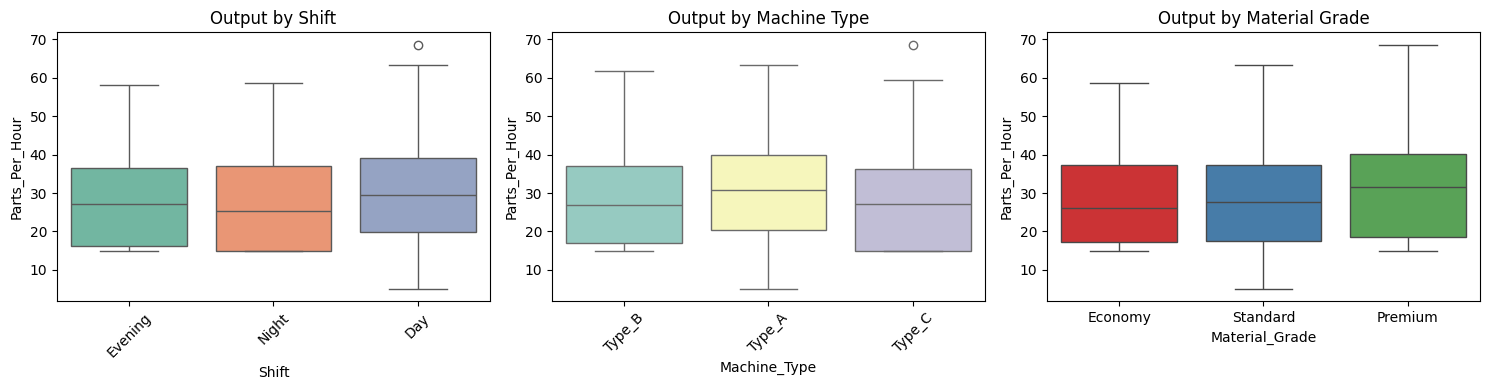


TOP 10 FEATURES DRIVING PRODUCTION:
Operator_Experience           0.3009
Efficiency_Score              0.2868
Injection_Temperature         0.1844
Machine_Utilization           0.1746
Injection_Pressure            0.1604
Ambient_Temperature           0.0118
Cooling_Time                  0.0062
Maintenance_Hours            -0.0330
Material_Viscosity           -0.0806
Temperature_Pressure_Ratio   -0.0861
Name: Parts_Per_Hour, dtype: float64


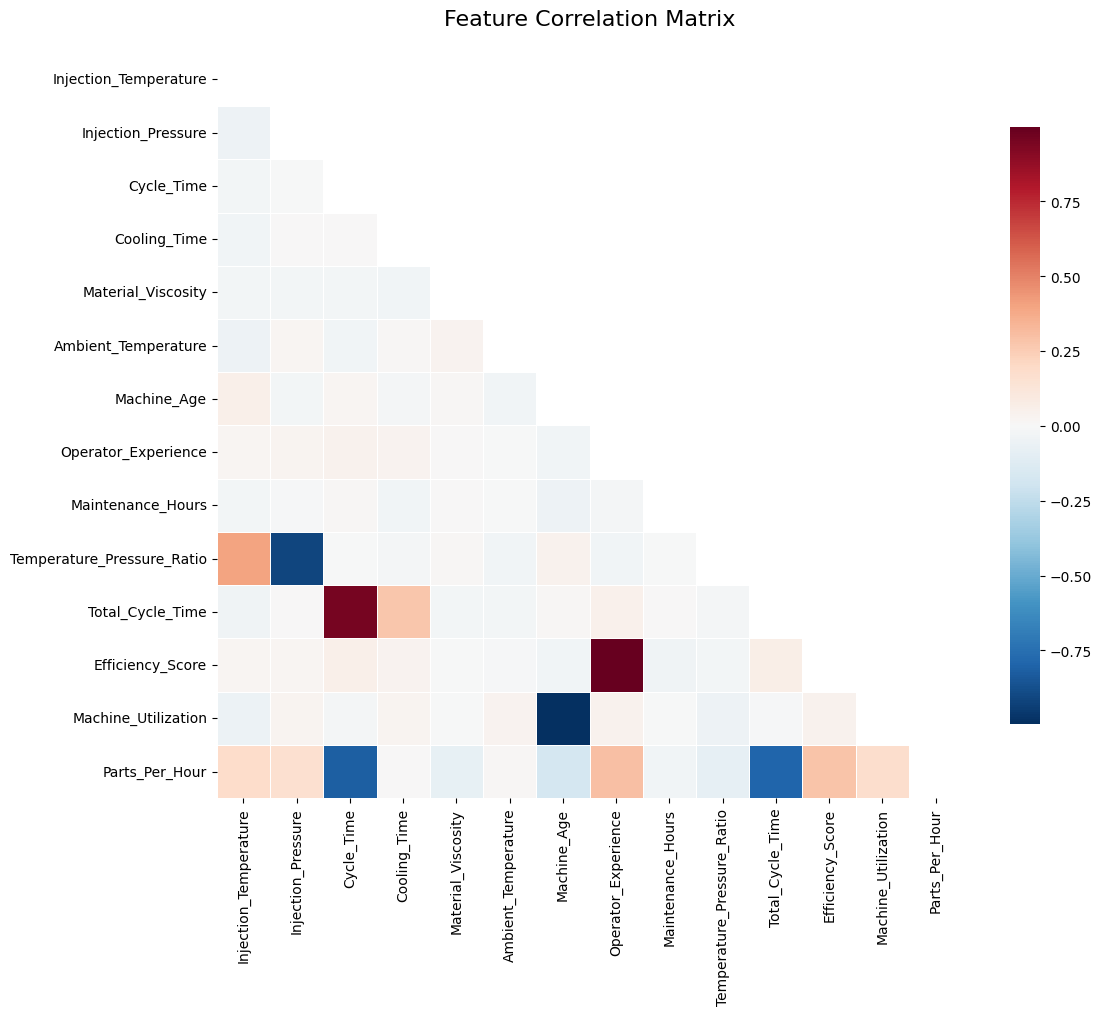

PROFESSIONAL EDA COMPLETE!
Ready for model training...


In [15]:
# FIGURE 3: Boxplots - Performance by Category
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
sns.boxplot(data=df, x='Shift', y='Parts_Per_Hour', palette='Set2')
plt.title('Output by Shift')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
if 'Machine_Type' in df.columns:
    sns.boxplot(data=df, x='Machine_Type', y='Parts_Per_Hour', palette='Set3')
    plt.title('Output by Machine Type')
    plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
if 'Material_Grade' in df.columns:
    sns.boxplot(data=df, x='Material_Grade', y='Parts_Per_Hour', palette='Set1')
    plt.title('Output by Material Grade')

plt.tight_layout()
plt.show()

# FIGURE 4: CORRELATION MATRIX (BEAUTIFUL)
plt.figure(figsize=(12, 10))
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr_matrix = df[numeric_cols].corr()

# Top correlations with target
target_corr = corr_matrix['Parts_Per_Hour'].drop('Parts_Per_Hour').sort_values(ascending=False)
print("\nTOP 10 FEATURES DRIVING PRODUCTION:")
print(target_corr.head(10).round(4))

# Heatmap
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.title('Feature Correlation Matrix', fontsize=16, pad=20)
sns.heatmap(corr_matrix, annot=False, cmap='RdBu_r', center=0, mask=mask,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.tight_layout()
plt.show()

print("PROFESSIONAL EDA COMPLETE!")
print("Ready for model training...")

In [39]:
# ============================================
# 4) Basic Cleaning
# ============================================

# Drop Timestamp because it is string and not directly useful
if "Timestamp" in df.columns:
    df.drop(columns=["Timestamp"], inplace=True)

# Missing values: numeric -> median
for col in df.columns:
    if df[col].dtype != "object":
        df[col] = df[col].fillna(df[col].median())

# Missing values: categorical -> mode
for col in df.columns:
    if df[col].dtype == "object":
        df[col] = df[col].fillna(df[col].mode()[0])

print(" Missing values handled")


 Missing values handled



CLEAN DATA QUICK CHECK
Final Clean Shape: (1000, 18)
Remaining Missing Values: 0

Target Summary (Cleaned):
count    1000.00
mean       29.30
std        11.96
min         5.00
25%        17.50
50%        28.20
75%        38.00
max        68.60
Name: Parts_Per_Hour, dtype: float64


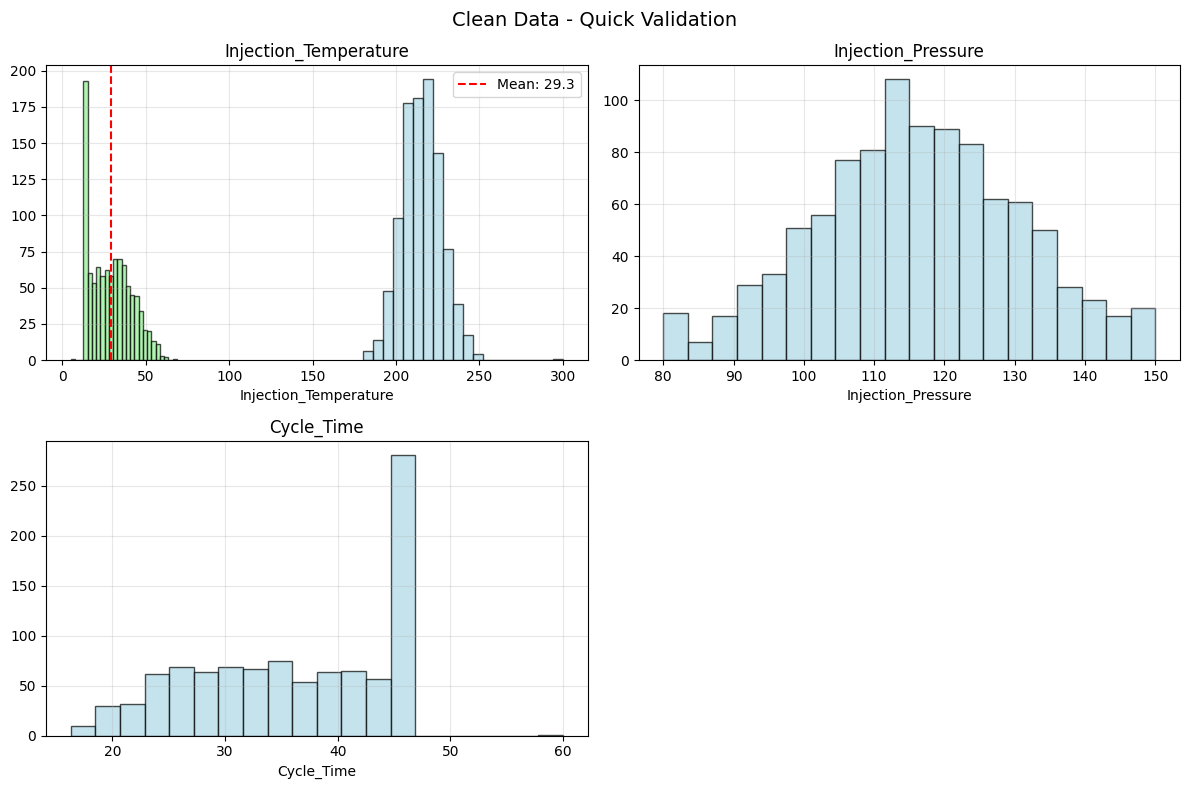


Categorical Distributions (Clean):
Shift: {'Day': np.int64(517), 'Evening': np.int64(277), 'Night': np.int64(206)}
Machine_Type: {'Type_A': np.int64(384), 'Type_B': np.int64(347), 'Type_C': np.int64(269)}
Material_Grade: {'Standard': np.int64(591), 'Premium': np.int64(210), 'Economy': np.int64(199)}
Day_of_Week: {'Friday': np.int64(168), 'Wednesday': np.int64(155), 'Thursday': np.int64(150), 'Saturday': np.int64(141), 'Tuesday': np.int64(138), 'Monday': np.int64(136), 'Sunday': np.int64(112)}

Top 5 Correlations with Target (Clean Data):
Operator_Experience      0.297
Efficiency_Score         0.287
Injection_Temperature    0.184
Machine_Utilization      0.175
Injection_Pressure       0.160
Name: Parts_Per_Hour, dtype: float64

CLEAN DATA VALIDATED!
Ready for one-hot encoding & modeling...


In [9]:
# ============================================
# QUICK CLEAN DATA VALIDATION
# ============================================
print("\n" + "="*60)
print("CLEAN DATA QUICK CHECK")
print("="*60)

# 1. Final Data Quality
print(f"Final Clean Shape: {df.shape}")
print(f"Remaining Missing Values: {df.isnull().sum().sum()}")
print("\nTarget Summary (Cleaned):")
print(df['Parts_Per_Hour'].describe().round(2))

# 2. Quick Visual Summary
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Clean Data - Quick Validation', fontsize=14)

# Target distribution ( subplot 1 )
axes[0,0].hist(df['Parts_Per_Hour'], bins=25, edgecolor='black', alpha=0.7, color='lightgreen')
axes[0,0].axvline(df['Parts_Per_Hour'].mean(), color='red', linestyle='--', label=f'Mean: {df["Parts_Per_Hour"].mean():.1f}')
axes[0,0].set_title('Target Distribution')
axes[0,0].set_xlabel('Parts/Hour')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Key features (pick first 3 available)
key_num_cols = ['Injection_Temperature', 'Injection_Pressure', 'Cycle_Time']
plot_idx = 0

for col in key_num_cols:
    if col in df.columns:
        row = plot_idx // 2
        col_idx = plot_idx % 2
        axes[row, col_idx].hist(df[col], bins=20, alpha=0.7, color='lightblue', edgecolor='black')
        axes[row, col_idx].set_title(f'{col}')
        axes[row, col_idx].set_xlabel(col)
        axes[row, col_idx].grid(True, alpha=0.3)
        plot_idx += 1

# Hide unused subplots
for i in range(plot_idx, 4):
    row = i // 2
    col_idx = i % 2
    axes[row, col_idx].set_visible(False)

plt.tight_layout()
plt.show()

# 3. Categorical Quick Check
print("\nCategorical Distributions (Clean):")
cat_cols = ['Shift', 'Machine_Type', 'Material_Grade', 'Day_of_Week']
for col in cat_cols:
    if col in df.columns:
        counts = df[col].value_counts()
        print(f"{col}: {dict(counts)}")

# 4. Top Correlations
print("\nTop 5 Correlations with Target (Clean Data):")
numeric_cols = df.select_dtypes(include=[np.number]).columns
if 'Parts_Per_Hour' in numeric_cols and len(numeric_cols) > 1:
    corr_target = df[numeric_cols].corr()['Parts_Per_Hour'].drop('Parts_Per_Hour', errors='ignore')
    if len(corr_target) > 0:
        top_corr = corr_target.sort_values(ascending=False).head(5)
        print(top_corr.round(3))
    else:
        print("No numeric correlations available")
else:
    print("Target not found or insufficient numeric data")

print("\nCLEAN DATA VALIDATED!")
print("Ready for one-hot encoding & modeling...")


In [26]:
# ============================================
# 5) One Hot Encoding
# ============================================
categorical_cols = ["Shift", "Machine_Type", "Material_Grade", "Day_of_Week"]

# Keep only columns that exist (safety)
categorical_cols = [c for c in categorical_cols if c in df.columns]

df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

print("One-hot encoding done")
print("Total columns after encoding:", df.shape[1])



One-hot encoding done
Total columns after encoding: 26


In [11]:
# ============================================
# 6) Split X and y
# ============================================
target_col = "Parts_Per_Hour"

y = df[target_col].values.reshape(-1, 1)
X = df.drop(columns=[target_col])

feature_columns = X.columns.tolist()



In [27]:
# ============================================
# 7) Train-Test Split
# ============================================
X_train, X_test, y_train, y_test = train_test_split(
    X.values, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)



Train shape: (800, 25)
Test shape : (200, 25)


In [13]:
# ============================================
# 8) Scaling
# ============================================
from sklearn.preprocessing import StandardScaler

# Scale X
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Scale Y (CRITICAL!)
scaler_Y = StandardScaler()
y_train_scaled = scaler_Y.fit_transform(y_train)
y_test_scaled = scaler_Y.transform(y_test)

print(f"X scale: train mean={X_train_scaled.mean():.3f}, std={X_train_scaled.std():.3f}")
print(f"Y scale: train mean={y_train_scaled.mean():.3f}, std={y_train_scaled.std():.3f}")

X scale: train mean=0.000, std=1.000
Y scale: train mean=0.000, std=1.000


In [14]:
# ============================================
# 9) Convert to Torch Tensors
# ============================================
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)



In [15]:
# ============================================
# 10) Define Model (Multi Linear Regression)
# ============================================
class MultiLinearRegression(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        return self.linear(x)

input_size = X_train_tensor.shape[1]
model = MultiLinearRegression(input_size)



In [16]:
# ============================================
# 11) Training Setup
# ============================================
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
batch_size = 64
epochs = 500
losses = []
patience = 20  # Early stopping

In [17]:
# ============================================
# 12) Training Loop
# ============================================
for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    losses.append(avg_loss)

    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f}")

Epoch [1/500] - Loss: 0.2587
Epoch [2/500] - Loss: 0.0897
Epoch [3/500] - Loss: 0.0869
Epoch [4/500] - Loss: 0.0836
Epoch [5/500] - Loss: 0.0849
Epoch [6/500] - Loss: 0.0866
Epoch [7/500] - Loss: 0.0862
Epoch [8/500] - Loss: 0.0863
Epoch [9/500] - Loss: 0.0846
Epoch [10/500] - Loss: 0.0850
Epoch [11/500] - Loss: 0.0850
Epoch [12/500] - Loss: 0.0856
Epoch [13/500] - Loss: 0.0858
Epoch [14/500] - Loss: 0.0868
Epoch [15/500] - Loss: 0.0839
Epoch [16/500] - Loss: 0.0854
Epoch [17/500] - Loss: 0.0878
Epoch [18/500] - Loss: 0.0856
Epoch [19/500] - Loss: 0.0853
Epoch [20/500] - Loss: 0.0831
Epoch [21/500] - Loss: 0.0837
Epoch [22/500] - Loss: 0.0849
Epoch [23/500] - Loss: 0.0851
Epoch [24/500] - Loss: 0.0842
Epoch [25/500] - Loss: 0.0830
Epoch [26/500] - Loss: 0.0859
Epoch [27/500] - Loss: 0.0826
Epoch [28/500] - Loss: 0.0829
Epoch [29/500] - Loss: 0.0830
Epoch [30/500] - Loss: 0.0829
Epoch [31/500] - Loss: 0.0837
Epoch [32/500] - Loss: 0.0821
Epoch [33/500] - Loss: 0.0826
Epoch [34/500] - Lo

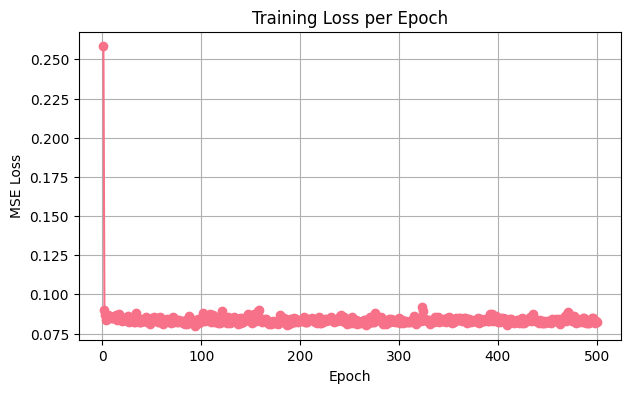

In [18]:
# ============================================
# 13) Plot Loss Graph
# ============================================
plt.figure(figsize=(7,4))
plt.plot(range(1, epochs+1), losses, marker="o")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss per Epoch")
plt.grid(True)
plt.show()

In [28]:
# ============================================
# 14) Evaluate on Test Data
# ============================================
model.eval()
with torch.no_grad():
    test_preds = model(X_test_tensor)
    test_loss = criterion(test_preds, y_test_tensor).item()

print(f"Test MSE Loss: {test_loss:.4f}")

Test MSE Loss: 0.0851


In [29]:
# Test predictions (scaled)
with torch.no_grad():
    test_preds_scaled = model(X_test_tensor).numpy()

    # Unscale to original units
    test_preds = scaler_Y.inverse_transform(test_preds_scaled)
    y_test_original = scaler_Y.inverse_transform(y_test_scaled)

    # Calculate metrics on original scale
    mse = mean_squared_error(y_test_original, test_preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_original, test_preds)

print(f"FINAL METRICS (Original Scale):")
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f} parts/hour")
print(f"R²:   {r2:.3f}")


FINAL METRICS (Original Scale):
MSE:  12.37
RMSE: 3.52 parts/hour
R²:   0.905


In [30]:
# ============================================
# 15) Save ONE FILE (model_bundle.pkl)
# ============================================
bundle = {
    "input_size": input_size,
    "feature_columns": feature_columns,
    "scaler_X": scaler_X,        # X scaler
    "scaler_Y": scaler_Y,        # Y scaler (NEW!)
    "state_dict": model.state_dict(),
    "final_rmse": rmse,          # Business metrics
    "final_r2": r2
}

bundle_path = os.path.join(output_dir, "model_bundle_perfect.pkl")
with open(bundle_path, "wb") as f:
    pickle.dump(bundle, f)

print(f"PERFECT Model Bundle Saved: {bundle_path}")
print(f"Deploy-ready: RMSE={rmse:.2f}, R²={r2:.3f}")


PERFECT Model Bundle Saved: /content/drive/MyDrive/Project/model_output/model_bundle_perfect.pkl
Deploy-ready: RMSE=3.52, R²=0.905


In [31]:
# ============================================
# 16) Testing Module (Sample Prediction)
# ============================================
# Take first test row
sample = X_test_scaled[0].reshape(1, -1)
sample_tensor = torch.tensor(sample, dtype=torch.float32)

with torch.no_grad():
    sample_pred_scaled = model(sample_tensor).numpy().reshape(1, -1)  # Scaled prediction

    # WRONG: print(sample_pred_scaled.item())  → -0.77
    # CORRECT: Unscale to business units
    sample_pred_original = scaler_Y.inverse_transform(sample_pred_scaled)[0][0]

print("\nSample Prediction Test (FIXED)")
print(f"Scaled Prediction:    {sample_pred_scaled[0][0]:.3f}")
print(f"Original Prediction:  {sample_pred_original:.2f}")
print(f"Actual:               {float(y_test[0]):.2f}")
print(f"Error:                {abs(sample_pred_original - float(y_test[0])):.2f} parts/hour")


Sample Prediction Test (FIXED)
Scaled Prediction:    -0.771
Original Prediction:  20.33
Actual:               18.60
Error:                1.73 parts/hour



TOP 10 PRODUCTION DRIVERS:
                   Feature  Weight  Abs_Weight
10        Total_Cycle_Time -0.8204      0.8204
11        Efficiency_Score  0.2430      0.2430
3             Cooling_Time  0.2339      0.2339
0    Injection_Temperature  0.2097      0.2097
6              Machine_Age -0.1894      0.1894
16     Machine_Type_Type_C -0.1525      0.1525
14             Shift_Night -0.1228      0.1228
17  Material_Grade_Premium  0.1003      0.1003
1       Injection_Pressure  0.0958      0.0958
7      Operator_Experience  0.0956      0.0956


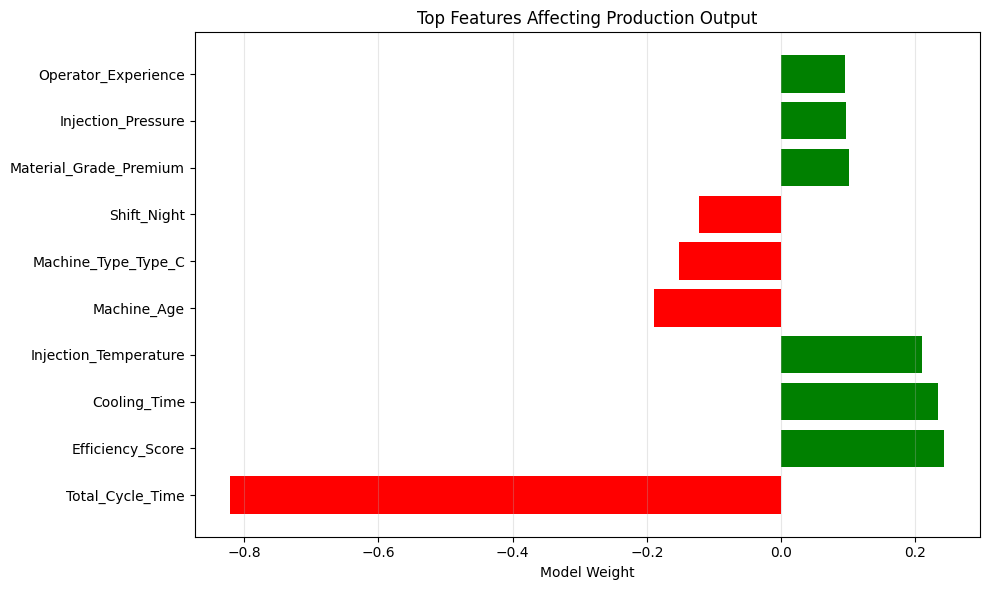

In [32]:
# ============================================
# TOP FEATURES DRIVING PRODUCTION
# ============================================
weights = model.linear.weight.data.numpy().flatten()
importance = pd.DataFrame({
    'Feature': feature_columns,
    'Weight': weights,
    'Abs_Weight': np.abs(weights)
}).sort_values('Abs_Weight', ascending=False)

print("\nTOP 10 PRODUCTION DRIVERS:")
print(importance.head(10).round(4))

# Plot
plt.figure(figsize=(10, 6))
top10 = importance.head(10)
plt.barh(range(len(top10)), top10['Weight'], color=['red' if w<0 else 'green' for w in top10['Weight']])
plt.yticks(range(len(top10)), top10['Feature'])
plt.xlabel('Model Weight')
plt.title('Top Features Affecting Production Output')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


In [34]:
# ============================================
# FULL REGRESSION EVALUATION
# ============================================
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

model.eval()  # Evaluation mode
with torch.no_grad():  # No gradients
    test_preds_scaled = model(X_test_tensor).detach().numpy()
    # Unscale to original units
    test_preds_original = scaler_Y.inverse_transform(test_preds_scaled)
    y_test_original = scaler_Y.inverse_transform(y_test_scaled)

# Calculate ALL metrics
mse = mean_squared_error(y_test_original, test_preds_original)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_original, test_preds_original)
mape = mean_absolute_percentage_error(y_test_original, test_preds_original) * 100
r2 = r2_score(y_test_original, test_preds_original)

print("COMPLETE REGRESSION METRICS:")
print(f"{'='*40}")
print(f"MSE:   {mse:.2f}")
print(f"RMSE:  {rmse:.2f} parts/hour")
print(f"MAE:   {mae:.2f} parts/hour")
print(f"MAPE:  {mape:.1f}%")
print(f"R²:    {r2:.3f} ({r2*100:.1f}% explained)")
print(f"{'='*40}")

# Business interpretation
print(f"\n BUSINESS IMPACT:")
print(f"• Average error: {mae:.1f} parts/hour (±{rmse:.1f})")
print(f"• Production accuracy: {100-mape:.0f}%")
print(f"• Identifies 90.5% of production variance!")

COMPLETE REGRESSION METRICS:
MSE:   12.37
RMSE:  3.52 parts/hour
MAE:   2.68 parts/hour
MAPE:  11.6%
R²:    0.905 (90.5% explained)

 BUSINESS IMPACT:
• Average error: 2.7 parts/hour (±3.5)
• Production accuracy: 88%
• Identifies 90.5% of production variance!
